# **Assignment 1: Translation with a Sequence to Sequence Network** 🤖

This assignment is split into two sections: **Neural Machine Translation** with (1) **RNNs** and (2) **Transformer**. To be more specifically, in Machine Translation, our goal is to convert a sentence from the source language (e.g. Vietnamese) to the target language (e.g. English). In this assignment, we will implement a sequence-to-sequence (**Seq2Seq**) network based on two architectures: **RNNs with Attention** and **Transformer**, to build a **Neural Machine Translation (NMT) system**.

<img src="https://drive.google.com/uc?id=1ltoz1Yr_6QTyR8bHd4wzOh3J03abwRg4"/>

That's a lot to digest, the goal of this assignment is to break it down into easy to understand parts. In this assignment you will:

- [Data Preparation](#data-preparation): A machine cannot directly understand "Tôi yêu bạn" the way humans do. We must first prepare and preprocess the data into a format the machine can comprehend.
- **Seq2Seq Model Build:** After preparing the necessary data, we proceed to build our Seq2Seq model for the machine translation task.
    - [RNNs with Attention Architecture]():
        - **Embedding Layer:** initialize layer to convert input words to their embeddings.
        - **Initialize Layers:** declare basic layers of our model.
        - **The Encoder & Decoder:** implement the `encode` function to obtain encoder hidden states from source sentences and `decode` function to compute combined output vectors for a batch inputs.

    - [Transformer Architecture]():
        - **Positional embeddings:** initialize layer to combines token embeddings with positional embeddings. Unlike RNNs, the Transformer architecture processes all input tokens in parallel. Therefore, positional embeddings are added to provide the information of order and position of elements in an input sequence, which is crucial for our machine translation tasks.
        - **Transformer Layer:** implement the `forward` pass function with the help of transformer library.

- **Train & Test our two models:** The training and testing code are provided for you.
- [Generate translations](): The model uses either the `beam_search` or `greedy` function to generate translations in the target language. While `beam_search` is provided as the standard for testing, you are required to implement the `greedy` method.

**Requirements**

Firstly, apart from standards libraries, we need to install some package:

1. `sentencepiece`: To build your own vocabulary \\
2. `sacrebleu`: To evaluate our model using BLUE score metric

In [ ]:
%%capture
!pip install sentencepiece==0.1.97
!pip install tqdm==4.29.1
!pip install sacrebleu
!pip install nltk
!pip install 'portalocker>=2.0.0'

Below, we import our standard libraries.

In [ ]:
#@title Standard libraries
# Standard libraries
import sys
import json
import time
import math
import numpy as np
from typing import List, Tuple, Dict, Set, Union
from collections import Counter, namedtuple
from itertools import chain
from dataclasses import dataclass

# to compute BLUE score
import sacrebleu

# Pytorch
import torch
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

# To train vocabulary
import sentencepiece as spm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#@title Default hyperparameters
@dataclass
class Args:
    cuda: str = "cuda:0"
    train_src: str = "data/train.vi"
    train_tgt: str = "data/train.en"
    dev_src: str = "data/dev.vi"
    dev_tgt: str = 'data/dev.en'
    vocab_file: str = 'vocab.json'
    src_vocab_size: int = 15000
    tgt_vocab_size: int = 21000
    seed: int = 0
    batch_size: int = 32
    max_len: int = 320
    embed_size: int = 1024
    hidden_size: int = 768
    clip_grad: float = 5.0                  # gradient clipping
    log_every: int = 10                     # log every
    max_epoch: int = 100                     # max epoch
    patience: int = 5                       # wait for how many iterations to decay learning rate
    max_num_trial: int = 5                  # terminate training after how many trials
    lr_decay: float = 0.5                   # learning rate decay
    beam_size: int = 5                      # beam size
    lr: float = 0.001                       # learning rate
    uniform_init: float = 0.1               # uniformly initialize all parameters
    model_save_path: str = 'lstm_model.bin' # model save path
    valid_niter: int = 2000                 # perform validation after how many iterations
    dropout: float = 0.3
    max_decoding_time_step: int = 70        # maximum number of decoding time steps

args = Args()
device = torch.device(args.cuda) if torch.cuda.is_available() else torch.device("cpu")

seed = int(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed * 13 // 7)

# Let's start your assignment implementation 💪


# Data Preparation

A machine cannot directly understand "Tôi yêu bạn" the way humans do. We must first prepare and preprocess the data into a format the machine can comprehend.

Below is a visual representation of the data preparation process using two sample data points. The steps are as follows:

1. Download and load the data.
2. Construct our `Vocab` from a list of subwords generated by `SentencePiece` ([github](https://github.com/google/sentencepiece)) for both the source and target languages.
3. Apply `SentencePiece` to encode raw text into subwords and add special tokens for target data.
3. Apply padding to ensure all elements in the same batch have the same length.
4. Convert the padded batch into a tensor using word ids from our `Vocab`.



<img src="https://drive.google.com/uc?id=1z9E_s55APC_pAGzpuuvENzvJqnHRz8j6"/>

If you're not yet familiar with tensors in PyTorch, you can visit this link for more information: [Tensor tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html)


## Loading data files
The data for this project is a set of thousands of Vietnamese to
English translation pairs. We will download them first then save to 'data' folder.

In [ ]:
%%capture
!mkdir data

import os
import re

def download_file(google_drive_link, to_save_path):
    match = re.search(r"/file/d/(.*?)/", google_drive_link)
    file_id = match.group(1) if match else None
    new_path = f"https://drive.google.com/uc?id={file_id}"

    os.system(f"wget --no-check-certificate {new_path} -O {to_save_path}")



data_path = 'https://drive.google.com/file/d/1eq68XlKxWBFCj4YgMRl2N5YdrZvB9FDs/view?usp=sharing'
download_file(data_path, args.train_src)

data_path = 'https://drive.google.com/file/d/1679j2kIvdl8Oe_WRSX0vi62JtOrhr1GD/view?usp=sharing'
download_file(data_path, args.train_tgt)


data_path = 'https://drive.google.com/file/d/1p0tBxnD-MVXyve772omfq1nFDraeI_sO/view?usp=sharing'
download_file(data_path, args.dev_src)

data_path = 'https://drive.google.com/file/d/1ZvBBTUwzYJuN4J8WCZ9-kZiBEm4iPpiL/view?usp=sharing'
download_file(data_path, args.dev_tgt)

## Logging data files

Understanding the appearance of our data serves as a solid starting point when addressing the issue. The data will be recorded in the source-target (src-tgt) format, featuring raw, unprocessed text. In the subsequent section, you will observe how the data undergoes preprocessing into a more suitable format, specifically using a sub-word tokenizer, to enhance the machine's comprehension.

In [ ]:
def read_file(file_path):
  """ Read file, where each sentence is dilineated by a `\n`.
  @param file_path (str): path to file containing corpus
  """
  data = []
  with open(file_path, 'r', encoding='utf8') as f:
    for line in f:
      data.append(line.strip())

  return data

In [ ]:
def logging_data(file_path_src, file_path_tgt, num_data):
    """ Read file, where each sentence is dilineated by a `\n`.
    @param file_path (str): path to file containing corpus
    """

    data_src = read_file(file_path_src)
    data_tgt = read_file(file_path_tgt)

    for i in range(num_data):
      print("Src sent: ", data_src[i])
      print("Tgt sent: ", data_tgt[i])
      print("\n")

In [ ]:
logging_data(args.train_src, args.train_tgt, 5)

Src sent:  Khoa học đằng sau một tiêu đề về khí hậu
Tgt sent:  Rachel Pike : The science behind a climate headline


Src sent:  Trong 4 phút , chuyên gia hoá học khí quyển Rachel Pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình -- hàng ngàn người đã cống hiến cho dự án này -- một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt .
Tgt sent:  In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .


Src sent:  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Tgt sent:  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the

## Q1: Padding function (5 points)
In order to apply tensor operations, we must ensure that the sentences in a given batch are of the same length. Thus, we must identify the longest sentence in a batch and pad others to be the same length. Implement the `pad_sents` function, which shall produce these padded sentences.

In [ ]:
def pad_sents(sents, pad_token):
    """ Pad list of sentences according to the longest sentence in the batch.
        The paddings should be at the end of each sentence.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded = []

    ### YOUR CODE HERE (~6 Lines)

    ### END YOUR CODE

    return sents_padded

In [ ]:
sents = [
    "VietAI là tổ chức phi lợi nhuận.",
    "Theo báo cáo mới nhất của Linkedin về danh sách việc làm triển vọng với mức lương hấp dẫn năm 2020, các chức danh công việc liên quan đến AI đều xếp thứ hạng cao.",
    "Sứ mệnh của VietAI là ươm mầm tài năng về trí tuệ nhân tạo và xây dựng một cộng đồng các chuyên gia trong lĩnh vực trí tuệ nhân tạo đẳng cấp quốc tế."
    "Chúng ta đang trên hành trình tiến bộ và dân chủ hoá trí tuệ nhân tạo thông qua mã nguồn mở và khoa học mở"]

sents = [s.split() for s in sents]
padded_sents = pad_sents(sents, pad_token="<PAD>")

for sent in padded_sents:
    assert len(sent) == len(padded_sents[0])

Below, we define the `VocabEntry` class. The `VocabEntry` class is a vocabulary entry that contains a dictionary that maps words to indices and provides methods to convert words to indices, indices to words, and sentences to tensors. The purpose of this class is to facilitate the management of the vocabulary.

In [ ]:
class VocabEntry(object):
    """ Vocabulary Entry, i.e. structure containing either
    src or tgt language terms.
    """
    def __init__(self, word2id=None):
        """ Init VocabEntry Instance.
        @param word2id (dict): dictionary mapping words 2 indices
        """
        if word2id:
            self.word2id = word2id
        else:
            self.word2id = dict()
            self.word2id['<pad>'] = 0   # Pad Token
            self.word2id['<s>'] = 1 # Start Token
            self.word2id['</s>'] = 2    # End Token
            self.word2id['<unk>'] = 3   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        """ Retrieve word's index. Return the index for the unk
        token if the word is out of vocabulary.
        @param word (str): word to look up.
        @returns index (int): index of word
        """
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        """ Check if word is captured by VocabEntry.
        @param word (str): word to look up
        @returns contains (bool): whether word is contained
        """
        return word in self.word2id

    def __setitem__(self, key, value):
        """ Raise error, if one tries to edit the VocabEntry.
        """
        raise ValueError('vocabulary is readonly')

    def __len__(self):
        """ Compute number of words in VocabEntry.
        @returns len (int): number of words in VocabEntry
        """
        return len(self.word2id)

    def __repr__(self):
        """ Representation of VocabEntry to be used
        when printing the object.
        """
        return 'Vocabulary[size=%d]' % len(self)

    def id2word(self, wid):
        """ Return mapping of index to word.
        @param wid (int): word index
        @returns word (str): word corresponding to index
        """
        return self.id2word[wid]

    def add(self, word):
        """ Add word to VocabEntry, if it is previously unseen.
        @param word (str): word to add to VocabEntry
        @return index (int): index that the word has been assigned
        """
        if word not in self:
            wid = self.word2id[word] = len(self)
            self.id2word[wid] = word
            return wid
        else:
            return self[word]

    def words2indices(self, sents):
        """ Convert list of words or list of sentences of words
        into list or list of list of indices.
        @param sents (list[str] or list[list[str]]): sentence(s) in words
        @return word_ids (list[int] or list[list[int]]): sentence(s) in indices
        """
        try:
            if type(sents[0]) == list:
                for i in range(len(sents)):
                    # set max length
                    sents[i] = sents[i][:args.max_len]
                return [[self[w] for w in s] for s in sents]
            else:
                # set max length
                sents = sents[:args.max_len]
                return [[self[w] for w in sents]]
        except Exception as e:
            print(e, sents)
            return []

    def indices2words(self, word_ids):
        """ Convert list of indices into words.
        @param word_ids (list[int]): list of word ids
        @return sents (list[str]): list of words
        """
        return [self.id2word[w_id] for w_id in word_ids]

    def to_input_tensor(self, sents: List[List[str]], device: torch.device = device) -> torch.Tensor:
        """ Convert list of sentences (words) into tensor with necessary padding for
        shorter sentences.

        @param sents (List[List[str]]): list of sentences (words)
        @param device: device on which to load the tesnor, i.e. CPU or GPU

        @returns sents_var: tensor of (max_sentence_length, batch_size)
        """
        word_ids = self.words2indices(sents)
        sents_t = pad_sents(word_ids, self['<pad>'])
        sents_var = torch.tensor(sents_t, dtype=torch.long, device=device)
        return torch.t(sents_var)

    @staticmethod
    def from_corpus(corpus, size, freq_cutoff=2):
        """ Given a corpus construct a Vocab Entry.
        @param corpus (list[str]): corpus of text produced by read_corpus function
        @param size (int): # of words in vocabulary
        @param freq_cutoff (int): if word occurs n < freq_cutoff times, drop the word
        @returns vocab_entry (VocabEntry): VocabEntry instance produced from provided corpus
        """
        vocab_entry = VocabEntry()
        word_freq = Counter(chain(*corpus))
        valid_words = [w for w, v in word_freq.items() if v >= freq_cutoff]
        print('number of word types: {}, number of word types w/ frequency >= {}: {}'
              .format(len(word_freq), freq_cutoff, len(valid_words)))
        top_k_words = sorted(valid_words, key=lambda w: word_freq[w], reverse=True)[:size]
        for word in top_k_words:
            vocab_entry.add(word)
        return vocab_entry

    @staticmethod
    def from_subword_list(subword_list):
        vocab_entry = VocabEntry()
        for subword in subword_list:
            vocab_entry.add(subword)
        return vocab_entry

Afterwards, we use a `Vocab` class to wrap vocabulary used for both the source and target languages in a machine translation task. It is composed of two `VocabEntry` objects, one for the source language and one for the target language.

The build method is used to construct a `Vocab` object from a list of subwords generated by `SentencePiece` for both the source and target languages. Then, we save them to a JSON file.

In [ ]:
class Vocab(object):
    """ Vocab encapsulating src and target langauges.
    """
    def __init__(self, src_vocab: VocabEntry, tgt_vocab: VocabEntry):
        """ Init Vocab.
        @param src_vocab (VocabEntry): VocabEntry for source language
        @param tgt_vocab (VocabEntry): VocabEntry for target language
        """
        self.src = src_vocab
        self.tgt = tgt_vocab

    @staticmethod
    def build(src_sents, tgt_sents) -> 'Vocab':
        """ Build Vocabulary.
        @param src_sents (list[str]): Source subwords provided by SentencePiece
        @param tgt_sents (list[str]): Target subwords provided by SentencePiece
        """

        print('initialize source vocabulary ..')
        src = VocabEntry.from_subword_list(src_sents)

        print('initialize target vocabulary ..')
        tgt = VocabEntry.from_subword_list(tgt_sents)

        return Vocab(src, tgt)

    def save(self, file_path):
        """ Save Vocab to file as JSON dump.
        @param file_path (str): file path to vocab file
        """
        with open(file_path, 'w') as f:
            json.dump(dict(src_word2id=self.src.word2id, tgt_word2id=self.tgt.word2id), f, indent=2)

    @staticmethod
    def load(file_path):
        """ Load vocabulary from JSON dump.
        @param file_path (str): file path to vocab file
        @returns Vocab object loaded from JSON dump
        """
        entry = json.load(open(file_path, 'r'))
        src_word2id = entry['src_word2id']
        tgt_word2id = entry['tgt_word2id']

        return Vocab(VocabEntry(src_word2id), VocabEntry(tgt_word2id))

    def __repr__(self):
        """ Representation of Vocab to be used
        when printing the object.
        """
        return 'Vocab(source %d words, target %d words)' % (len(self.src), len(self.tgt))


def get_vocab_list(file_path, source, vocab_size):
    """ Use SentencePiece to tokenize and acquire list of unique subwords.
    @param file_path (str): file path to corpus
    @param source (str): tgt or src
    @param vocab_size: desired vocabulary size
    """
    spm.SentencePieceTrainer.Train(input=file_path, model_prefix=source, vocab_size=vocab_size)     # train the spm model
    sp = spm.SentencePieceProcessor()   # create an instance; this saves .model and .vocab files
    sp.Load('{}.model'.format(source))  # loads tgt.model or src.model
    sp_list = [sp.IdToPiece(piece_id) for piece_id in range(sp.GetPieceSize())] # this is the list of subwords
    return sp_list

## Train and save our vocabulary to a json file

In [ ]:
print('read in source sentences: %s' % args.train_src)
print('read in target sentences: %s' % args.train_tgt)

src_sents = get_vocab_list(args.train_src, source='src', vocab_size=args.src_vocab_size)
tgt_sents = get_vocab_list(args.train_tgt, source='tgt', vocab_size=args.tgt_vocab_size)
vocab = Vocab.build(src_sents, tgt_sents)
print('generated vocabulary, source %d words, target %d words' % (len(src_sents), len(tgt_sents)))

vocab.save(args.vocab_file)
print('vocabulary saved to %s' % args.vocab_file)

read in source sentences: data/train.vi
read in target sentences: data/train.en
initialize source vocabulary ..
initialize target vocabulary ..
generated vocabulary, source 15000 words, target 21000 words
vocabulary saved to vocab.json


## Read sentence pairs for training
The full process for preparing the data is:

- Read text file  into pairs
- Encode raw text into subwords
- Add word lists into our data

In [ ]:
def read_corpus(file_path, source):
    """ Read file, where each sentence is dilineated by a `\n`.
    @param file_path (str): path to file containing corpus
    @param source (str): "tgt" or "src" indicating whether text
        is of the source language or target language
    """
    data = []
    sp = spm.SentencePieceProcessor()
    sp.load('{}.model'.format(source))

    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            subword_tokens = sp.encode_as_pieces(line)
            # only append <s> and </s> to the target sentence
            if source == 'tgt':
                subword_tokens = ['<s>'] + subword_tokens + ['</s>']
            data.append(subword_tokens)

    return data

train_data_src = read_corpus(args.train_src, source='src')
train_data_tgt = read_corpus(args.train_tgt, source='tgt')

dev_data_src = read_corpus(args.dev_src, source='src')
dev_data_tgt = read_corpus(args.dev_tgt, source='tgt')

train_data = list(zip(train_data_src, train_data_tgt))
dev_data = list(zip(dev_data_src, dev_data_tgt))

We will visualize certain pairs of training data after encoding into subwords to gain insights into the data. It becomes evident that when raw text is encoded into subwords, a single word can be represented as the concatenation of other subwords. For instance, `"Trong"` transforms into `"_Tro"` and `"ng"` while `"dòng"` transforms into `"_dò"` and `"ng"`. Both examples will share the `"ng"` in common, reduce the number of item needed in the vocab size.

In [ ]:
n = 5
for i in range(n):
  print("Src sent: " + "|".join(train_data_src[i]))
  print("Tgt sent: " + "|".join(train_data_tgt[i]))
  print("\n")

Src sent: ▁Khoa|▁học|▁đ|ằng|▁sau|▁một|▁tiêu|▁đề|▁về|▁khí|▁hậu
Tgt sent: <s>|▁Rachel|▁P|ike|▁|:|▁The|▁science|▁|behind|▁a|▁climate|▁headline|</s>


Src sent: ▁Tro|ng|▁4|▁phút|▁,|▁chuyên|▁gia|▁hoá|▁học|▁khí|▁quyển|▁Rachel|▁P|ike|▁giới|▁t|hiệu|▁sơ|▁lược|▁về|▁những|▁nỗ|▁lực|▁khoa|▁học|▁m|iệt|▁mà|i|▁đ|ằng|▁sau|▁những|▁tiêu|▁đề|▁táo|▁bạo|▁về|▁biến|▁đổi|▁khí|▁hậu|▁,|▁cùng|▁với|▁đoàn|▁nghiên|▁cứu|▁của|▁mình|▁--|▁hàng|▁ngàn|▁người|▁đã|▁cố|ng|▁|hiến|▁cho|▁dự|▁án|▁này|▁--|▁một|▁chuyến|▁bay|▁mạo|▁hiểm|▁qua|▁rừng|▁già|▁để|▁tìm|▁kiếm|▁thông|▁tin|▁về|▁một|▁phân|▁tử|▁the|n|▁chố|t|▁.
Tgt sent: <s>|▁In|▁4|▁minutes|▁|,|▁atmospher|ic|▁chemist|▁Rachel|▁P|ike|▁provide|s|▁a|▁glimpse|▁of|▁the|▁massive|▁scientific|▁effort|▁|behind|▁the|▁bold|▁headline|s|▁on|▁climate|▁change|▁|,|▁with|▁her|▁team|▁--|▁one|▁of|▁|thousands|▁who|▁contribute|d|▁--|▁|taking|▁a|▁risk|y|▁flight|▁over|▁the|▁rainforest|▁in|▁pursuit|▁of|▁data|▁on|▁a|▁key|▁molecule|▁.|</s>


Src sent: ▁Tôi|▁muốn|▁cho|▁các|▁bạn|▁biết|▁về|▁sự|▁to|▁lớn|▁của|▁

We define the `batch_iter` function to iterate through the given data in batches of a specified size, where each batch contains source and target sentences.

The sentences are sorted in reverse order by their length, so that longer sentences come first.

The function takes three arguments: the data to iterate through, the batch size, and a flag indicating whether to shuffle the data randomly or not.

In [ ]:
def batch_iter(data, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    batch_num = math.ceil(len(data) / batch_size)
    index_array = list(range(len(data)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        examples = [data[idx] for idx in indices]

        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
        src_sents, tgt_sents = list(), list()
        for src_sent, tgt_sent in examples:
            if len(src_sent) > 0 and len(tgt_sent) > 0:
                src_sents.append(src_sent)
                tgt_sents.append(tgt_sent)
        yield src_sents, tgt_sents

We will print the tensor output of sample sentences (or words) to visualize how they are represented, with necessary padding applied to shorter sentences for a batch size of 2. You will notice that the output contains numbers representing the word IDs of their corresponding words (e.g., 0 for `<PAD>`, 1 for `<s>`, and 2 for `</s>`). This tensor will be used during both training and evaluation, and you can find the `batch_iter` and `to_input_tensor` functions in the respective sections.

In [ ]:
for src_sents, tgt_sents in batch_iter(dev_data, batch_size=2):
  src_tensor = vocab.src.to_input_tensor(src_sents)
  tgt_tensor = vocab.tgt.to_input_tensor(tgt_sents)

  print("SOURCE TENSOR: ", src_tensor)
  print("TARGET TENSOR: ", tgt_tensor)
  break

SOURCE TENSOR:  tensor([[ 700,  196],
        [  68,  841],
        [ 161,  163],
        [   7,   22],
        [  10,  324],
        [  21,  195],
        [ 192,  636],
        [ 940,    5],
        [  20,    0],
        [ 529,    0],
        [ 662,    0],
        [  41,    0],
        [ 541,    0],
        [  27,    0],
        [ 936,    0],
        [ 327,    0],
        [ 195,    0],
        [  11,    0],
        [  18,    0],
        [ 304,    0],
        [ 317,    0],
        [ 159,    0],
        [ 456,    0],
        [  46,    0],
        [ 187,    0],
        [   4,    0],
        [  41,    0],
        [  61,    0],
        [  36,    0],
        [  46,    0],
        [  79,    0],
        [  11,    0],
        [ 541,    0],
        [  27,    0],
        [ 936,    0],
        [ 401,    0],
        [1109,    0],
        [ 377,    0],
        [ 212,    0],
        [ 697,    0],
        [ 134,    0],
        [  23,    0],
        [8757,    0],
        [ 100,    0],
        [ 167,  

# The Seq2Seq Model 1: RNNs with global attention

In this section, we describe the training procedure for the proposed NMT system, which uses a Bidirectional LSTM Encoder and a Unidirectional LSTM Decoder.

<img src="https://i.ibb.co/pjRW6tC/arc.png" alt="arc" border="0" width=70%>

# Model description (training procedure)

Given a sentence in the source language, we look up the character or word embeddings from an **embeddings matrix**, yielding $x_1,...,x_m (x_i \in \mathbb{R}^e)$, where $m$ is the length of the source sentence and e is the embedding size. We feed the embeddings to the bidirectional encoder, yielding hidden states and cell states for both the forwards (→) and backwards (←) LSTMs. The forwards and backwards versions are concatenated to give hidden states $h^{enc}_i$ and cell states $c^{enc}_i$ :

$$ h^{enc}_i = [\overleftarrow{h^{enc}_i}; \overrightarrow{h^{enc}_i}] \:\: \text{where} \:\: h^{enc}_i \in \mathbb{R}^{2h \times 1} $$
$$ c^{enc}_i = [\overleftarrow{c^{enc}_i}; \overrightarrow{c^{enc}_i}] \:\: \text{where} \:\: c^{enc}_i \in \mathbb{R}^{2h \times 1} $$ \\

We then initialize the **decoder**’s first hidden state $h^{enc}_0$ and cell state $c^{enc}_0$  with a linear projection of the encoder’s final hidden state and final cell state.

$$ h^{dec}_0 = W_h[\overleftarrow{h^{enc}_1}; \overrightarrow{h^{enc}_m}] \:\: \text{where} \:\: h^{dec}_0 \in \mathbb{R}^{h \times 1} $$
$$ c^{dec}_0 = W_c[\overleftarrow{c^{enc}_1}; \overrightarrow{c^{enc}_m}] \:\: \text{where} \:\: c^{dec}_0 \in \mathbb{R}^{h \times 1} $$ \\

With the decoder initialized, we must now feed it a target sentence. On the $t^{th}$ step, we look up the embedding for the $t^{th}$ subword, $y_t \in \mathbb{R}^{e \times 1}$ . We then concatenate $y_t$ with the combined-output vector $o_{t-1} \in \mathbb{R}^{h \times 1}$ from the previous timestep (we will explain what this is later!) to produce $\bar{y_t} \in \mathbb{R}^{(e+h) \times 1}$. Note that for the first target subword (i.e. the start token) $o_0$ is a zero-vector. We then feed $\bar{y_t}$ as input to the decoder.


$$ h^{dec}_t , c^{dec}_t = \text{Decoder}(\bar{y_t},  h^{dec}_{t-1} , c^{dec}_{t-1} ) \:\:\: \text{where} \:\:\: h^{dec}_t \in \mathbb{R}^{h \times 1} , c^{dec}_t \in \mathbb{R}^{h \times 1} $$ \\

We then use $h^{dec}_t$ to compute multiplicative attention over $h^{enc}_1,...,, h^{enc}_m$ :

$$ e_{t,i} = (h_t^{dec})^TW_{attProj}h^{enc}_i \:\:\: \text{where} \:\:\: e_t \in \mathbb{R}^{m \times 1}, W_{attProj} \in \mathbb{R}^{h \times 2h} $$

$$ \alpha_t = softmax(e_t) \:\:\: \text{where} \:\:\: \alpha_t \in \mathbb{R}^{m \times 1}$$

$$ a_t = ∑_{i=1}^m \alpha_{t, i} h^{enc}_i \:\:\: \text{where} \:\:\: a_t \in \mathbb{R}^{2h \times 1}$$ \\

We now concatenate the attention output $a_t$ with the decoder hidden state $h^{dec}_t$ and pass this through a linear layer, tanh, and dropout to attain the *combined-output* vector $o_t$.

$$ u_t = [a_t;h^{dec}_t] \:\:\: \text{where} \:\:\: u_t \in \mathbb{R}^{3h \times 1} $$

$$ v_t = W_uu_t \:\:\: where \:\:\: v_t \in \mathbb{R}^{h \times 1},W_u \in \mathbb{R}^{h \times 3h}$$

$$ o_t = dropout(tanh(v_t)) \:\:\: where \:\:\: o_t \in \mathbb{R}^{h \times 1}$$ \\

Then, we produce a probability distribution $P_t$ over target subwords at the $t^{th}$ timestep:

$$ P_t = softmax(W_{vocab}o_t) \:\:\: where \:\:\: P_t \in \mathbb{R}^{V_t \times 1}, W_{vocab}\in \mathbb{R}^{V_t \times h} $$

Here, $V_t$ is the size of the target vocabulary. Finally, to train the network we then compute the cross entropy loss between $P_t$ and $g_t$, where $g_t$ is the one-hot vector of the target subword at timestep $t$:

$$ J_t(θ) = CrossEntropy(P_t, g_t)$$
Here, $θ$ represents all the parameters of the model and $J_t(θ)$ is the loss on step t of the decoder.

Now that we have described the model, let’s try implementing it Mandarin Vietnamese to English translation!




## Q2 (5 points) Embedding Layer Initilization

Implement the `__init__` function to initialize the necessary source and target embeddings.

In [ ]:
class ModelEmbeddings(nn.Module):
    """
    Class that converts input words to their embeddings.
    """
    def __init__(self, embed_size, vocab):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        """
        super(ModelEmbeddings, self).__init__()
        self.embed_size = embed_size

        # default values
        self.source = None
        self.target = None

        src_pad_token_idx = vocab.src['<pad>']
        tgt_pad_token_idx = vocab.tgt['<pad>']

        ### YOUR CODE HERE (~2 Lines)
        ### TODO - Initialize the following variables:
        ###     self.source (Embedding Layer for source language)
        ###     self.target (Embedding Layer for target langauge)
        ###
        ### Note:
        ###     1. `vocab` object contains two vocabularies:
        ###            `vocab.src` for source
        ###            `vocab.tgt` for target
        ###     2. You can get the length of a specific vocabulary by running:
        ###             `len(vocab.<specific_vocabulary>)`
        ###     3. Remember to include the padding token for the specific vocabulary
        ###        when creating your Embedding.
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Embedding Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        

        ### END YOUR CODE

## Q3-6 RNN with Global attention NMT model


### Q3 (10 points) Initialize layers in NMT model
Implement the `init` function to initialize the necessary model layers (LSTM, projection, and dropout) for the NMT system.

###  Q4 (15 points) Encoder
Implement the `encode` function. This function converts the padded source sentences into the tensor $X$, generates $h^{enc}_1 , . . . , h^{enc}_m $, and computes the initial state $h^{dec}_0$ and initial cell  $h^{dec}_0$ for the $\text{Decoder}$


### Q5 (15 points) Decoder
Implement the `decode` function. This function constructs $\bar{y}$ and runs the step function over every timestep for the input.



### Q6: (20 points) Decoder step
Implement the `step` function. This function applies the Decoder’s LSTM cell for a single timestep, computing the encoding of the target subword $h^{dec}_t$ , the attention scores $e_t$, attention distribution $\alpha_t$, the attention output $a_t$, and finally the combined output $o_t$.

In [ ]:
Hypothesis = namedtuple('Hypothesis', ['value', 'score'])

class NMT(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """

    def __init__(self, embed_size, hidden_size, vocab, dropout_rate=0.2):
        """ Init NMT Model.

        @param embed_size (int): Embedding size (dimensionality)
        @param hidden_size (int): Hidden Size, the size of hidden states (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        @param dropout_rate (float): Dropout probability, for attention
        """
        super(NMT, self).__init__()
        self.model_embeddings = ModelEmbeddings(embed_size, vocab)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab

        # default values
        self.encoder = None
        self.decoder = None
        self.h_projection = None
        self.c_projection = None
        self.att_projection = None
        self.combined_output_projection = None
        self.target_vocab_projection = None
        self.dropout = None
        # For sanity check only, not relevant to implementation
        self.gen_sanity_check = False
        self.counter = 0

        ### YOUR CODE HERE (~9 Lines)
        ### TODO - Initialize the following variables IN THIS ORDER:
        ###     self.post_embed_cnn (Conv1d layer with kernel size 2, input and output channels = embed_size,
        ###         padding = same to preserve output shape )
        ###     self.encoder (Bidirectional LSTM with bias)
        ###     self.decoder (LSTM Cell with bias)
        ###     self.h_projection (Linear Layer with no bias), called W_{h} .
        ###     self.c_projection (Linear Layer with no bias), called W_{c} .
        ###     self.att_projection (Linear Layer with no bias), called W_{attProj}.
        ###     self.combined_output_projection (Linear Layer with no bias), called W_{u}.
        ###     self.target_vocab_projection (Linear Layer with no bias), called W_{vocab}.
        ###     self.dropout (Dropout Layer)
        ###
        ### Use the following docs to properly initialize these variables:
        ###     LSTM:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        ###     LSTM Cell:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell
        ###     Linear Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        ###     Dropout Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
        ###     Conv1D Layer:
        ###         https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        

        ### END YOUR CODE

    def forward(self, source: List[List[str]], target: List[List[str]]) -> torch.Tensor:
        """ Take a mini-batch of source and target sentences, compute the log-likelihood of
        target sentences under the language models learned by the NMT system.

        @param source (List[List[str]]): list of source sentence tokens
        @param target (List[List[str]]): list of target sentence tokens, wrapped by `<s>` and `</s>`

        @returns scores (Tensor): a variable/tensor of shape (b, ) representing the
                                    log-likelihood of generating the gold-standard target sentence for
                                    each example in the input batch. Here b = batch size.
        """
        # Compute sentence lengths
        # source_lengths = [len(s) for s in source]
        source_lengths = [len(s) if len(s) <= args.max_len else args.max_len for s in source]

        # Convert list of lists into tensors
        source_padded = self.vocab.src.to_input_tensor(source, device=self.device)  # Tensor: (src_len, b)
        target_padded = self.vocab.tgt.to_input_tensor(target, device=self.device)  # Tensor: (tgt_len, b)

        ###     Run the network forward:
        ###     1. Apply the encoder to `source_padded` by calling `self.encode()`
        ###     2. Generate sentence masks for `source_padded` by calling `self.generate_sent_masks()`
        ###     3. Apply the decoder to compute combined-output by calling `self.decode()`
        ###     4. Compute log probability distribution over the target vocabulary using the
        ###        combined_outputs returned by the `self.decode()` function.

        enc_hiddens, dec_init_state = self.encode(source_padded, source_lengths)
        enc_masks = self.generate_sent_masks(enc_hiddens, source_lengths)
        combined_outputs = self.decode(enc_hiddens, enc_masks, dec_init_state, target_padded)
        P = F.log_softmax(self.target_vocab_projection(combined_outputs), dim=-1)

        # Zero out, probabilities for which we have nothing in the target text
        target_masks = (target_padded != self.vocab.tgt['<pad>']).float()

        # Compute log probability of generating true target words
        target_gold_words_log_prob = torch.gather(P, index=target_padded[1:].unsqueeze(-1), dim=-1).squeeze(
            -1) * target_masks[1:]
        scores = target_gold_words_log_prob.sum(dim=0)
        return scores

    def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[
        torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """ Apply the encoder to source sentences to obtain encoder hidden states.
            Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

        @param source_padded (Tensor): Tensor of padded source sentences with shape (src_len, b), where
                                        b = batch_size, src_len = maximum source sentence length. Note that
                                       these have already been sorted in order of longest to shortest sentence.
        @param source_lengths (List[int]): List of actual lengths for each of the source sentences in the batch
        @returns enc_hiddens (Tensor): Tensor of hidden units with shape (b, src_len, h*2), where
                                        b = batch size, src_len = maximum source sentence length, h = hidden size.
        @returns dec_init_state (tuple(Tensor, Tensor)): Tuple of tensors representing the decoder's initial
                                                hidden state and cell. Both tensors should have shape (2, b, h).
        """
        enc_hiddens, dec_init_state = None, None

        ### YOUR CODE HERE (~ 11 Lines)
        ### TODO:
        ###     1. Construct Tensor `X` of source sentences with shape (src_len, b, e) using the source model embeddings.
        ###         src_len = maximum source sentence length, b = batch size, e = embedding size. Note
        ###         that there is no initial hidden state or cell for the encoder.
        ###     2. Apply the post_embed_cnn layer. Before feeding X into the CNN, first use torch.permute to change the
        ###         shape of X to (b, e, src_len). After getting the output from the CNN, still stored in the X variable,
        ###         remember to use torch.permute again to revert X back to its original shape.
        ###     3. Compute `enc_hiddens`, `last_hidden`, `last_cell` by applying the encoder to `X`.
        ###         - Before you can apply the encoder, you need to apply the `pack_padded_sequence` function to X.
        ###         - After you apply the encoder, you need to apply the `pad_packed_sequence` function to enc_hiddens.
        ###         - Note that the shape of the tensor output returned by the encoder RNN is (src_len, b, h*2) and we want to
        ###           return a tensor of shape (b, src_len, h*2) as `enc_hiddens`, so you may need to do more permuting.
        ###         - Note on using pad_packed_sequence -> For batched inputs, you need to make sure that each of the
        ###           individual input examples has the same shape.
        ###     4. Compute `dec_init_state` = (init_decoder_hidden, init_decoder_cell):
        ###         - `init_decoder_hidden`:
        ###             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the h_projection layer to this in order to compute init_decoder_hidden.
        ###             This is h_0^{dec} in the PDF. Here b = batch size, h = hidden size
        ###         - `init_decoder_cell`:
        ###             `last_cell` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the c_projection layer to this in order to compute init_decoder_cell.
        ###             This is c_0^{dec} in the PDF. Here b = batch size, h = hidden size
        ###
        ### See the following docs, as you may need to use some of the following functions in your implementation:
        ###     Pack the padded sequence X before passing to the encoder:
        ###         https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
        ###     Pad the packed sequence, enc_hiddens, returned by the encoder:
        ###         https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html
        ###     Tensor Concatenation:
        ###         https://pytorch.org/docs/stable/generated/torch.cat.html
        ###     Tensor Permute:
        ###         https://pytorch.org/docs/stable/generated/torch.permute.html
        ###     Tensor Reshape (a possible alternative to permute):
        ###         https://pytorch.org/docs/stable/generated/torch.Tensor.reshape.html
        
        
        ### END YOUR CODE

        return enc_hiddens, dec_init_state

    def decode(self, enc_hiddens: torch.Tensor, enc_masks: torch.Tensor,
               dec_init_state: Tuple[torch.Tensor, torch.Tensor], target_padded: torch.Tensor) -> torch.Tensor:
        """Compute combined output vectors for a batch.

        @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                     b = batch size, src_len = maximum source sentence length, h = hidden size.
        @param enc_masks (Tensor): Tensor of sentence masks (b, src_len), where
                                     b = batch size, src_len = maximum source sentence length.
        @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
        @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                       tgt_len = maximum target sentence length, b = batch size.

        @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                        tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
        """
        # Chop off the <END> token for max length sentences.
        target_padded = target_padded[:-1]

        # Initialize the decoder state (hidden and cell)
        dec_state = dec_init_state

        # Initialize previous combined output vector o_{t-1} as zero
        batch_size = enc_hiddens.size(0)
        o_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)

        # Initialize a list we will use to collect the combined output o_t on each step
        combined_outputs = []

        ### YOUR CODE HERE (~9 Lines)
        ### TODO:
        ###     1. Apply the attention projection layer to `enc_hiddens` to obtain `enc_hiddens_proj`,
        ###         which should be shape (b, src_len, h),
        ###         where b = batch size, src_len = maximum source length, h = hidden size.
        ###         This is applying W_{attProj} to h^enc, as described in the PDF.
        ###     2. Construct tensor `Y` of target sentences with shape (tgt_len, b, e) using the target model embeddings.
        ###         where tgt_len = maximum target sentence length, b = batch size, e = embedding size.
        ###     3. Use the torch.split function to iterate over the time dimension of Y.
        ###         Within the loop, this will give you Y_t of shape (1, b, e) where b = batch size, e = embedding size.
        ###             - Squeeze Y_t into a tensor of dimension (b, e).
        ###             - Construct Ybar_t by concatenating Y_t with o_prev on their last dimension
        ###             - Use the step function to compute the the Decoder's next (cell, state) values
        ###               as well as the new combined output o_t.
        ###             - Append o_t to combined_outputs
        ###             - Update o_prev to the new o_t.
        ###     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
        ###         tensors shape (b, h), to a single tensor shape (tgt_len, b, h)
        ###         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.
        ###
        ### Note:
        ###    - When using the squeeze() function make sure to specify the dimension you want to squeeze
        ###      over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
        ###
        ### You may find some of these functions useful:
        ###     Zeros Tensor:
        ###         https://pytorch.org/docs/stable/torch.html#torch.zeros
        ###     Tensor Splitting (iteration):
        ###         https://pytorch.org/docs/stable/torch.html#torch.split
        ###     Tensor Dimension Squeezing:
        ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
        ###     Tensor Concatenation:
        ###         https://pytorch.org/docs/stable/torch.html#torch.cat
        ###     Tensor Stacking:
        ###         https://pytorch.org/docs/stable/torch.html#torch.stack


        ### END YOUR CODE

        return combined_outputs

    def step(self, Ybar_t: torch.Tensor,
             dec_state: Tuple[torch.Tensor, torch.Tensor],
             enc_hiddens: torch.Tensor,
             enc_hiddens_proj: torch.Tensor,
             enc_masks: torch.Tensor) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
        """ Compute one forward step of the LSTM decoder, including the attention computation.

        @param Ybar_t (Tensor): Concatenated Tensor of [Y_t o_prev], with shape (b, e + h). The input for the decoder,
                                where b = batch size, e = embedding size, h = hidden size.
        @param dec_state (tuple(Tensor, Tensor)): Tuple of tensors both with shape (b, h), where b = batch size, h = hidden size.
                First tensor is decoder's prev hidden state, second tensor is decoder's prev cell.
        @param enc_hiddens (Tensor): Encoder hidden states Tensor, with shape (b, src_len, h * 2), where b = batch size,
                                    src_len = maximum source length, h = hidden size.
        @param enc_hiddens_proj (Tensor): Encoder hidden states Tensor, projected from (h * 2) to h. Tensor is with shape (b, src_len, h),
                                    where b = batch size, src_len = maximum source length, h = hidden size.
        @param enc_masks (Tensor): Tensor of sentence masks shape (b, src_len),
                                    where b = batch size, src_len is maximum source length.

        @returns dec_state (tuple (Tensor, Tensor)): Tuple of tensors both shape (b, h), where b = batch size, h = hidden size.
                First tensor is decoder's new hidden state, second tensor is decoder's new cell.
        @returns combined_output (Tensor): Combined output Tensor at timestep t, shape (b, h), where b = batch size, h = hidden size.
        @returns e_t (Tensor): Tensor of shape (b, src_len). It is attention scores distribution.
                                Note: You will not use this outside of this function.
                                      We are simply returning this value so that we can sanity check
                                      your implementation.
        """

        combined_output = None

        ### YOUR CODE HERE (~3 Lines)
        ### TODO:
        ###     1. Apply the decoder to `Ybar_t` and `dec_state`to obtain the new dec_state.
        ###     2. Split dec_state into its two parts (dec_hidden, dec_cell)
        ###     3. Compute the attention scores e_t, a Tensor shape (b, src_len).
        ###        Note: b = batch_size, src_len = maximum source length, h = hidden size.
        ###
        ###       Hints:
        ###         - dec_hidden is shape (b, h) and corresponds to h^dec_t in the PDF (batched)
        ###         - enc_hiddens_proj is shape (b, src_len, h) and corresponds to W_{attProj} h^enc (batched).
        ###         - Use batched matrix multiplication (torch.bmm) to compute e_t (be careful about the input/ output shapes!)
        ###         - To get the tensors into the right shapes for bmm, you will need to do some squeezing and unsqueezing.
        ###         - When using the squeeze() function make sure to specify the dimension you want to squeeze
        ###             over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
        ###
        ### Use the following docs to implement this functionality:
        ###     Batch Multiplication:
        ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
        ###     Tensor Unsqueeze:
        ###         https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
        ###     Tensor Squeeze:
        ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
        

        ### END YOUR CODE

        # Set e_t to -inf where enc_masks has 1
        if enc_masks is not None:
            e_t.data.masked_fill_(enc_masks.bool(), -float('inf'))

        ### YOUR CODE HERE (~6 Lines)
        ### TODO:
        ###     1. Apply softmax to e_t to yield alpha_t
        ###     2. Use batched matrix multiplication between alpha_t and enc_hiddens to obtain the
        ###         attention output vector, a_t.
        # $$     Hints:
        ###           - alpha_t is shape (b, src_len)
        ###           - enc_hiddens is shape (b, src_len, 2h)
        ###           - a_t should be shape (b, 2h)
        ###           - You will need to do some squeezing and unsqueezing.
        ###     Note: b = batch size, src_len = maximum source length, h = hidden size.
        ###
        ###     3. Concatenate dec_hidden with a_t to compute tensor U_t
        ###     4. Apply the combined output projection layer to U_t to compute tensor V_t
        ###     5. Compute tensor O_t by first applying the Tanh function and then the dropout layer.
        ###
        ### Use the following docs to implement this functionality:
        ###     Softmax:
        ###         https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.softmax
        ###     Batch Multiplication:
        ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
        ###     Tensor View:
        ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view
        ###     Tensor Concatenation:
        ###         https://pytorch.org/docs/stable/torch.html#torch.cat
        ###     Tanh:
        ###         https://pytorch.org/docs/stable/torch.html#torch.tanh
        

        ### END YOUR CODE

        combined_output = O_t
        return dec_state, combined_output, e_t

    def generate_sent_masks(self, enc_hiddens: torch.Tensor, source_lengths: List[int]) -> torch.Tensor:
        """ Generate sentence masks for encoder hidden states.

        @param enc_hiddens (Tensor): encodings of shape (b, src_len, 2*h), where b = batch size,
                                     src_len = max source length, h = hidden size.
        @param source_lengths (List[int]): List of actual lengths for each of the sentences in the batch.

        @returns enc_masks (Tensor): Tensor of sentence masks of shape (b, src_len),
                                    where src_len = max source length, h = hidden size.
        """
        enc_masks = torch.zeros(enc_hiddens.size(0), enc_hiddens.size(1), dtype=torch.float)
        for e_id, src_len in enumerate(source_lengths):
            enc_masks[e_id, src_len:] = 1
        return enc_masks.to(self.device)

    def beam_search(self, src_sent: List[str], beam_size: int = 5, max_decoding_time_step: int = 70) -> List[
        Hypothesis]:
        """ Given a single source sentence, perform beam search, yielding translations in the target language.
        @param src_sent (List[str]): a single source sentence (words)
        @param beam_size (int): beam size
        @param max_decoding_time_step (int): maximum number of time steps to unroll the decoding RNN
        @returns hypotheses (List[Hypothesis]): a list of hypothesis, each hypothesis has two fields:
                value: List[str]: the decoded target sentence, represented as a list of words
                score: float: the log-likelihood of the target sentence
        """
        src_sents_var = self.vocab.src.to_input_tensor([src_sent], self.device)

        src_encodings, dec_init_vec = self.encode(src_sents_var, [len(src_sent)])
        src_encodings_att_linear = self.att_projection(src_encodings)

        h_tm1 = dec_init_vec
        att_tm1 = torch.zeros(1, self.hidden_size, device=self.device)

        eos_id = self.vocab.tgt['</s>']

        hypotheses = [['<s>']]
        hyp_scores = torch.zeros(len(hypotheses), dtype=torch.float, device=self.device)
        completed_hypotheses = []

        t = 0
        while len(completed_hypotheses) < beam_size and t < max_decoding_time_step:
            t += 1
            hyp_num = len(hypotheses)

            exp_src_encodings = src_encodings.expand(hyp_num,
                                                     src_encodings.size(1),
                                                     src_encodings.size(2))

            exp_src_encodings_att_linear = src_encodings_att_linear.expand(hyp_num,
                                                                           src_encodings_att_linear.size(1),
                                                                           src_encodings_att_linear.size(2))

            y_tm1 = torch.tensor([self.vocab.tgt[hyp[-1]] for hyp in hypotheses], dtype=torch.long, device=self.device)
            y_t_embed = self.model_embeddings.target(y_tm1)

            x = torch.cat([y_t_embed, att_tm1], dim=-1)

            (h_t, cell_t), att_t, _ = self.step(x, h_tm1,
                                                exp_src_encodings, exp_src_encodings_att_linear, enc_masks=None)

            # log probabilities over target words
            log_p_t = F.log_softmax(self.target_vocab_projection(att_t), dim=-1)

            live_hyp_num = beam_size - len(completed_hypotheses)
            contiuating_hyp_scores = (hyp_scores.unsqueeze(1).expand_as(log_p_t) + log_p_t).view(-1)
            top_cand_hyp_scores, top_cand_hyp_pos = torch.topk(contiuating_hyp_scores, k=live_hyp_num)

            prev_hyp_ids = torch.div(top_cand_hyp_pos, len(self.vocab.tgt), rounding_mode='floor')
            hyp_word_ids = top_cand_hyp_pos % len(self.vocab.tgt)

            new_hypotheses = []
            live_hyp_ids = []
            new_hyp_scores = []

            for prev_hyp_id, hyp_word_id, cand_new_hyp_score in zip(prev_hyp_ids, hyp_word_ids, top_cand_hyp_scores):
                prev_hyp_id = prev_hyp_id.item()
                hyp_word_id = hyp_word_id.item()
                cand_new_hyp_score = cand_new_hyp_score.item()

                hyp_word = self.vocab.tgt.id2word[hyp_word_id]
                new_hyp_sent = hypotheses[prev_hyp_id] + [hyp_word]
                if hyp_word == '</s>':
                    completed_hypotheses.append(Hypothesis(value=new_hyp_sent[1:-1],
                                                           score=cand_new_hyp_score))
                else:
                    new_hypotheses.append(new_hyp_sent)
                    live_hyp_ids.append(prev_hyp_id)
                    new_hyp_scores.append(cand_new_hyp_score)

            if len(completed_hypotheses) == beam_size:
                break

            live_hyp_ids = torch.tensor(live_hyp_ids, dtype=torch.long, device=self.device)
            h_tm1 = (h_t[live_hyp_ids], cell_t[live_hyp_ids])
            att_tm1 = att_t[live_hyp_ids]

            hypotheses = new_hypotheses
            hyp_scores = torch.tensor(new_hyp_scores, dtype=torch.float, device=self.device)

        if len(completed_hypotheses) == 0:
            completed_hypotheses.append(Hypothesis(value=hypotheses[0][1:],
                                                   score=hyp_scores[0].item()))

        completed_hypotheses.sort(key=lambda hyp: hyp.score, reverse=True)

        return completed_hypotheses

    @property
    def device(self) -> torch.device:
        """ Determine which device to place the Tensors upon, CPU or GPU.
        """
        return self.model_embeddings.source.weight.device

    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = NMT(vocab=params['vocab'], **args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the odel to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

        params = {
            'args': dict(embed_size=self.model_embeddings.embed_size, hidden_size=self.hidden_size,
                         dropout_rate=self.dropout_rate),
            'vocab': self.vocab,
            'state_dict': self.state_dict()
        }

        torch.save(params, path)

Now it’s time to get things running!

## Evaluating function


In [ ]:
def evaluate_ppl(model, dev_data, batch_size=32):
    """ Evaluate perplexity on dev sentences
    @param model (NMT): NMT Model
    @param dev_data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (batch size)
    @returns ppl (perplixty on dev sentences)
    """
    was_training = model.training
    model.eval()

    cum_loss = 0.
    cum_tgt_words = 0.

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for src_sents, tgt_sents in batch_iter(dev_data, batch_size):
            loss = -model(src_sents, tgt_sents).sum()

            cum_loss += loss.item()
            tgt_word_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            cum_tgt_words += tgt_word_num_to_predict

        ppl = np.exp(cum_loss / cum_tgt_words)

    if was_training:
        model.train()

    return ppl

def compute_corpus_level_bleu_score(references: List[List[str]], hypotheses: List[Hypothesis]) -> float:
    """ Given decoding results and reference sentences, compute corpus-level BLEU score.
    @param references (List[List[str]]): a list of gold-standard reference target sentences
    @param hypotheses (List[Hypothesis]): a list of hypotheses, one for each reference
    @returns bleu_score: corpus-level BLEU score
    """
    # remove the start and end tokens
    if references[0][0] == '<s>':
        references = [ref[1:-1] for ref in references]

    # detokenize the subword pieces to get full sentences
    detokened_refs = [''.join(pieces).replace('▁', ' ') for pieces in references]
    detokened_hyps = [''.join(hyp.value).replace('▁', ' ') for hyp in hypotheses]

    # sacreBLEU can take multiple references (golden example per sentence) but we only feed it one
    bleu = sacrebleu.corpus_bleu(detokened_hyps, [detokened_refs])

    return bleu.score, detokened_refs, detokened_hyps

## Training the model

In [ ]:
# Initialize our model and optimizer
model = NMT(embed_size=args.embed_size,
            hidden_size=args.hidden_size,
            dropout_rate=float(args.dropout),
            vocab=vocab)
model.train()

uniform_init = float(args.uniform_init)
if np.abs(uniform_init) > 0.:
    print('uniformly initialize parameters [-%f, +%f]' % (uniform_init, uniform_init), file=sys.stderr)
    for p in model.parameters():
        p.data.uniform_(-uniform_init, uniform_init)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=float(args.lr))

uniformly initialize parameters [-0.100000, +0.100000]


We wil first train our model on a small training set of 50 samples and evaluate it on a small dev set of 50 samples.

In [ ]:
max_train = 50

train_data_small = [val for val in train_data if len(val[0]) > 3][:max_train]
dev_data_small = [val for val in dev_data if len(val[0]) > 3][:max_train]

In [ ]:
num_trial = 0
train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0
cum_examples = report_examples = epoch = valid_num = 0
hist_valid_scores = []
train_time = begin_time = time.time()
print('begin Maximum Likelihood training')

for epoch in range(args.max_epoch):
    for src_sents, tgt_sents in batch_iter(train_data_small, batch_size=args.batch_size, shuffle=True):
        train_iter += 1

        optimizer.zero_grad()

        batch_size = len(src_sents)

        example_losses = -model(src_sents, tgt_sents) # (batch_size,)
        batch_loss = example_losses.sum()
        loss = batch_loss / batch_size

        loss.backward()

        # clip gradient
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)

        optimizer.step()

        batch_losses_val = batch_loss.item()
        report_loss += batch_losses_val
        cum_loss += batch_losses_val

        tgt_words_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
        report_tgt_words += tgt_words_num_to_predict
        cum_tgt_words += tgt_words_num_to_predict
        report_examples += batch_size
        cum_examples += batch_size

        if train_iter % args.log_every == 0:
            print('epoch %d, iter %d, avg. loss %.2f, avg. ppl %.2f ' \
                    'cum. examples %d, speed %.2f words/sec, time elapsed %.2f sec' % (epoch, train_iter,
                                                                                        report_loss / report_examples,
                                                                                        math.exp(report_loss / report_tgt_words),
                                                                                        cum_examples,
                                                                                        report_tgt_words / (time.time() - train_time),
                                                                                        time.time() - begin_time), file=sys.stderr)

            train_time = time.time()
            report_loss = report_tgt_words = report_examples = 0.

        # perform validation
        if train_iter % args.valid_niter == 0:
            print('epoch %d, iter %d, cum. loss %.2f, cum. ppl %.2f cum. examples %d' % (epoch, train_iter,
                                                                                        cum_loss / cum_examples,
                                                                                        np.exp(cum_loss / cum_tgt_words),
                                                                                        cum_examples), file=sys.stderr)

            cum_loss = cum_examples = cum_tgt_words = 0.
            valid_num += 1

            print('begin validation ...', file=sys.stderr)

            # compute dev. ppl and bleu
            dev_ppl = evaluate_ppl(model, dev_data, batch_size=128)   # dev batch size can be a bit larger
            valid_metric = -dev_ppl

            print('validation: iter %d, dev. ppl %f' % (train_iter, dev_ppl), file=sys.stderr)

            is_better = len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores)
            hist_valid_scores.append(valid_metric)

            if is_better:
                patience = 0
                print('save currently the best model to [%s]' % args.model_save_path, file=sys.stderr)
                model.save(args.model_save_path)

                # also save the optimizers' state
                torch.save(optimizer.state_dict(), args.model_save_path + '.optim')
            elif patience < int(args.patience):
                patience += 1
                print('hit patience %d' % patience, file=sys.stderr)

                if patience == int(args.patience):
                    num_trial += 1
                    print('hit #%d trial' % num_trial, file=sys.stderr)
                    if num_trial == int(args.max_num_trial):
                        print('early stop!', file=sys.stderr)
                        exit(0)

                    # decay lr, and restore from previously best checkpoint
                    lr = optimizer.param_groups[0]['lr'] * float(args.lr_decay)
                    print('load previously best model and decay learning rate to %f' % lr, file=sys.stderr)

                    # load model
                    params = torch.load(args.model_save_path, map_location=lambda storage, loc: storage)
                    model.load_state_dict(params['state_dict'])
                    model = model.to(device)

                    print('restore parameters of the optimizers', file=sys.stderr)
                    optimizer.load_state_dict(torch.load(args.model_save_path + '.optim'))

                    # set new lr
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr

                    # reset patience
                    patience = 0

begin Maximum Likelihood training


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
epoch 4, iter 10, avg. loss 195.20, avg. ppl 1529.50 cum. examples 250, speed 1564.53 words/sec, time elapsed 4.25 sec
epoch 9, iter 20, avg. loss 124.54, avg. ppl 107.60 cum. examples 500, speed 3153.94 words/sec, time elapsed 6.36 sec
epoch 14, iter 30, avg. loss 89.78, avg. ppl 29.16 cum. examples 750, speed 3157.14 words/sec, time elapsed 8.47 sec
epoch 19, iter 40, avg. loss 66.84, avg. ppl 12.31 cum. examples 1000, speed 3018.52 words/sec, time elapsed 10.68 sec
epoch 24, iter 50, avg. loss 54.15, avg. ppl 7.65 cum. examples 1250, speed 3353.35 words/sec, time elapsed 12.66 sec
epoch 29, iter 60, avg. loss 41.84, avg. ppl 4.82 cum. examples 1500, speed 3138.05 words/sec, time elapsed 14.78 sec

## Testing the model

Beam search is an algorithm used in many NLP and speech recognition models as a final decision making layer to choose the best output given target variables like maximum probability or next output character. The figure is referenced from the blog [Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html).

<img src="https://drive.google.com/uc?id=1rjVuANPjwTQi33beysq_LRNCxd6xhRHY" width="800" height="400"/>

The model uses `beam_search` function to yield the translations in the target language. `beam_search` will return a list of hypothesis for the translated sentences, each will have the value and the score for it, sorted in the descending order, so the first element in the Hypothesis is the best option for translated output by the model. The samples on training data should be very good with bleu score 100. The samples on validation data, however, probably won't make sense (because we're overfitting).

In [ ]:
# @title Testing on training set
references = []
hypotheses = []

num_logs = 5
if (num_logs > len(train_data_small)):
  num_logs = len(train_data_small)

for i in range(num_logs):
  src, tgt = train_data_small[i]
  references = [tgt]
  hypotheses = model.beam_search(src)
  bleu_score, detokened_refs, detokened_hyps = compute_corpus_level_bleu_score(references, hypotheses)
  print(f"Sample {i}:")
  print("Bleu score: " + str(bleu_score))
  print("Source: " + str(src))
  print("Reference: " + str(detokened_refs))
  print("Hypotheses: " + str(detokened_hyps))
  print('\n')

Sample 0:
Bleu score: 62.401954419369176
Source: ['▁Khoa', '▁học', '▁đ', 'ằng', '▁sau', '▁một', '▁tiêu', '▁đề', '▁về', '▁khí', '▁hậu']
Reference: [' Rachel Pike : The science behind a climate headline']
Hypotheses: [' Rachel Pike : The science behind the headline', ' Rachel Pike : The science behind the climate headline', ' Rachel Pike : The science behind they headline', ' Rachel Pike : The science behind a climate headlines .', ' Rachel Pike : The science behind the IPCC , put .']


Sample 1:
Bleu score: 100.00000000000004
Source: ['▁Tro', 'ng', '▁4', '▁phút', '▁,', '▁chuyên', '▁gia', '▁hoá', '▁học', '▁khí', '▁quyển', '▁Rachel', '▁P', 'ike', '▁giới', '▁t', 'hiệu', '▁sơ', '▁lược', '▁về', '▁những', '▁nỗ', '▁lực', '▁khoa', '▁học', '▁m', 'iệt', '▁mà', 'i', '▁đ', 'ằng', '▁sau', '▁những', '▁tiêu', '▁đề', '▁táo', '▁bạo', '▁về', '▁biến', '▁đổi', '▁khí', '▁hậu', '▁,', '▁cùng', '▁với', '▁đoàn', '▁nghiên', '▁cứu', '▁của', '▁mình', '▁--', '▁hàng', '▁ngàn', '▁người', '▁đã', '▁cố', 'ng', '▁', 'hiế

In [ ]:
# @title Testing on evaluate set
references = []
hypotheses = []

num_logs = 5
if (num_logs > len(dev_data_small)):
  num_logs = len(dev_data_small)

for i in range(num_logs):
  src, tgt = dev_data_small[i]
  references = [tgt]
  hypotheses = model.beam_search(src)
  bleu_score, detokened_refs, detokened_hyps = compute_corpus_level_bleu_score(references, hypotheses)
  print(f"Sample {i}:")
  print("Bleu score: " + str(bleu_score))
  print("Source: " + str(src))
  print("Reference: " + str(detokened_refs))
  print("Hypotheses: " + str(detokened_hyps))
  print('\n')

Sample 0:
Bleu score: 0.0012401113190363224
Source: ['▁Là', 'm', '▁sao', '▁tôi', '▁có', '▁thể', '▁trình', '▁bày', '▁trong', '▁10', '▁phút', '▁về', '▁sợ', 'i', '▁dây', '▁liên', '▁kết', '▁những', '▁người', '▁phụ', '▁nữ', '▁qua', '▁ba', '▁thế', '▁hệ', '▁,', '▁về', '▁việc', '▁làm', '▁thế', '▁nào', '▁những', '▁sợ', 'i', '▁dây', '▁mạnh', '▁mẽ', '▁đáng', '▁kinh', '▁ngạc', '▁ấy', '▁đã', '▁ní', 'u', '▁ch', 'ặt', '▁lấy', '▁cuộc', '▁sống', '▁của', '▁một', '▁cô', '▁bé', '▁bốn', '▁tuổi', '▁co', '▁qu', 'ắp', '▁với', '▁đ', 'ứa', '▁em', '▁gái', '▁nhỏ', '▁của', '▁cô', '▁bé', '▁,', '▁với', '▁mẹ', '▁và', '▁bà', '▁trong', '▁suốt', '▁năm', '▁ngày', '▁đêm', '▁trên', '▁con', '▁thuyền', '▁nhỏ', '▁lên', 'h', '▁đê', 'nh', '▁trên', '▁B', 'iển', '▁Đông', '▁hơn', '▁30', '▁năm', '▁trước', '▁,', '▁những', '▁sợ', 'i', '▁dây', '▁liên', '▁kết', '▁đã', '▁ní', 'u', '▁lấy', '▁cuộc', '▁đời', '▁cô', '▁bé', '▁ấy', '▁và', '▁không', '▁bao', '▁giờ', '▁', 'rời', '▁đi', '▁--', '▁cô', '▁bé', '▁ấy', '▁giờ', '▁sống', '▁ở', '▁San', '

# The Seq2Seq Model 2: Transformer
In this part, you will train a sequence-to-sequence Transformer model to translate Portuguese into English. The Transformer was originally proposed in "Attention is all you need" by Vaswani et al. (2017).

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 2: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

### The Embedding and Positional Encoding Layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

## Q7: Transformer Embedding Layer (10 points)
Implement `TransformerEmbedding` (consists of lookup embedding & positional encoding) for transformer model.

In [ ]:
class TransformerEmbedding(nn.Module):
    """
    Class that combines token embeddings with positional embeddings.
    """
    def __init__(self, vocab_size, embedding_size, max_len, dropout_rate):
        """
        Init the Transformer Embedding layer.

        @param vocab_size (int): Vocabulary size (number of unique tokens)
        @param embedding_size (int): Embedding size (dimensionality)
        @param max_len (int): Maximum sequence length
        @param dropout_rate (float): Dropout probability
        """
        super().__init__()
        # default values
        self.embedding_size = embedding_size
        self.token_embedding = None
        self.dropout = None
        pos_embedding = None

        ### YOUR CODE HERE
        ### TODO - Implement the positional embedding and Initialize the following variables :
        ###     self.token_embedding (Embedding Layer)
        ###     self.pos_embedding (Positional Embedding Layer), notes that pos_embedding is not learnable parameters,
        ###         so we should use the self.register_buffer function to initialize it.
        ###     self.dropout (Dropout Layer)
        ###
        ### Note:
        ###     1. `vocab_size` represents the size of the vocabulary (number of unique tokens)
        ###     2. `embedding_size` represents the size of each embedding vector
        ###     3. `max_len` represents the maximum sequence length
        ###     4. `dropout_rate` represents the dropout probability
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Embedding Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Embeddingl
        ###     Dropout Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
        ###
        

        ### END YOUR CODE
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, x):
        """
        Maps input sequences of tokens to their embeddings.

        @param x (Tensor): Input tensor of tokens with shape (seq_len, batch_size)

        @returns embedded (Tensor): Tensor of token embeddings with shape (seq_len, batch_size, embedding_size)
        """
        # Retrieve token embeddings
        ### YOUR CODE HERE (~1 Line) ###
        embedded_tokens = None

        # Retrieve positional embeddings for the appropriate segment of the input sequence
        ### YOUR CODE HERE (~1 Line) ###
        embedded_positions = None

        # Add token and positional embeddings together, apply dropout, and return
        ### YOUR CODE HERE (~1 Line) ###
        embedded = None

        return embedded

### Visualize the positional encoding

Positional encoding can be tricky to implement correctly, even if the code runs. Use the test visualization below to confirm it produces the expected sinusoidal shape.
The `PositionalEncoding` class is identical to the positional encoding logic within the `TransformerEmbedding`. We extracted it separately to facilitate debugging of the positional encoding values before their addition to the `embedded_tokens`. Copy the necessary code of `__init__` and `forward` of the positional encoding part for testing.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Class that combines token embeddings with positional embeddings.
    """
    def __init__(self, embedding_size, dropout_rate, max_len=5000):
        """
        Init the Transformer Embedding layer.

        @param vocab_size (int): Vocabulary size (number of unique tokens)
        @param embedding_size (int): Embedding size (dimensionality)
        @param max_len (int): Maximum sequence length
        @param dropout_rate (float): Dropout probability
        """
        super().__init__()
        # default values
        self.embedding_size = embedding_size
        self.dropout = None
        pos_embedding = None

        ### YOUR CODE HERE: COPY FROM YOUR PREVIOUS IMPLEMENTATION OF THE POSITIONAL ENCODING
        ### TODO - Implement the positional embedding and Initialize the following variables :
        ###     self.pos_embedding (Positional Embedding Layer), notes that pos_embedding is not learnable parameters,
        ###         so we should use the self.register_buffer function to initialize it.

        ### END YOUR CODE
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, x):
        """
        Maps input sequences of tokens to their embeddings.

        @param x (Tensor): Input tensor of tokens with shape (seq_len, batch_size)

        @returns embedded (Tensor): Tensor of token embeddings with shape (seq_len, batch_size, embedding_size)
        """

        # Retrieve positional embeddings for the appropriate segment of the input sequence
        ### YOUR CODE HERE (~1 Line) ###
        embedded_positions = None

        # Add token and positional embeddings together, apply dropout, and return
        ### YOUR CODE HERE (~1 Line) ###
        embedded = None
        
        return embedded

In [ ]:
#@title Visualize functions
import pandas as pd
import altair as alt

RUN_EXAMPLES = True

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

def example_positional():
    pe = PositionalEncoding(20, 0)
    # We simulate data with shape (100, 1, 20) where src_len = 100, b = 1, e = 20.
    y = pe.forward(torch.zeros(100, 1, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[: , 0, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

In [ ]:
show_example(example_positional)

alt.Chart(...)

## The Transformer model

To be convinient, we will use `nn.Transformer` layer from PyTorch. We will build a 4-layer Transformer model.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

## Q8-9 Transfomer NMT model

### Q8: (5 points) Initialize layers in TransformerNMT model
Implement the `__init__` function  to initialize the
necessary module for our TransformerNMT model

### Q9: (10 points) Implement the forward function
Complete the `forward` function in the TransformerNMT class



In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BOS_IDX, PAD_IDX, EOS_IDX, UNK_IDX = vocab.tgt["<s>"], vocab.tgt["<pad>"], vocab.tgt["</s>"], vocab.tgt["<unk>"]

class TransformerNMT(nn.Module):
    """ Neural Machine Translation Model with Transformer:
        - Encoder with stacked self-attention and feedforward layers
        - Decoder with stacked self-attention, encoder-decoder attention, and feedforward layers
    """
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 max_len: int = 5000,
                 dropout: float = 0.1):
        """ Init TransformerNMT NMT Model.
        @param num_encoder_layers (int): The number of sub-layers in the Encoder Transformer
        @param num_decoder_layers (int): The number of sub-layers in the Decoder Transformer
        @param emb_size (int): Hidden Size, the size of hidden states (dimensionality)
        @param nhead (int): The number of heads in the multiheadattention
        @param src_vocab_size (int): The vocab size of src languages
        @param tgt_vocab_size (int): The vocab size of tgt languages
        @param dim_feedforward (int): The dimension of the feedforward network model
        @param max_len (int) max sequence length
        @param dropout (float): Dropout probability, for attention
        """

        super(TransformerNMT, self).__init__()

        self.src_embedding = None
        self.tgt_embedding = None

        self.transformer = None
        self.target_vocab_projection = None

        ### YOUR CODE HERE
        ### TODO - Initialize the following variables IN THIS ORDER:
        ###     self.src_embedding: Transformer Embedding Layer used for source language
        ###     self.tgt_embedding: Transformer Embedding Layer used for target language
        ###     self.transformer: Transformer layer
        ###     self.target_vocab_projection (Linear Layer with no bias), mapping hidden representation to the vocab distribution
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Transformer
        ###         https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        

        ### END YOUR CODE


    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        """Forward pass through the neural machine translation (NMT) model.
        @param src (Tensor): Source sequence tensor.
        @param trg (Tensor): Target sequence tensor.
        @param src_mask (Tensor): Mask for the source sequence.
        @param tgt_mask (Tensor): Mask for the target sequence.
        @param src_padding_mask (Tensor): Padding mask for the source sequence.
        @param tgt_padding_mask (Tensor): Padding mask for the target sequence.
        @param memory_key_padding_mask (Tensor): Padding mask for memory keys.

        @returns Tensor: Output tensor representing the NMT model's predictions for the target sequence.
        """

        ### YOUR CODE HERE
        ### TODO - Implement the forward function:
        ###     1. Compute `src_embeded` and `tgt_embeded` from `src` and `tgt` using TransformerEmbedding,
        ###     which return shape (src_len, b, e)
        ###     src_len = maximum source sentence length, b = batch size, e = embedding size.
        ###     2. Apply the self.transformer to compute the decoder output with shape (tgt_len, b, e)
        ###     tgt_len = maximum target sentence length, b = batch size, e = embedding size.
        ###     3. Mapping the decoder ouput to the vocab distribution using self.target_vocab_projection and return it.
        ###     which return shape (tgt_len, b, tgt_vocab_size)

        ### Use the following docs for how to use nn.Transformer forward function:
        ###     Transformer
        ###         https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        
        
        ### END YOUR CODE

    def encode(self, src: Tensor, src_mask: Tensor):
        """Encodes the source sequence.
        @param src (Tensor): Source sequence tensor. (src_len, bs)
        @param src_mask (Tensor): Mask for the source sequence. (src_len, src_len)

        @returns Tensor: Encoded source sequence tensor. (src_len, bs, emb_size)
        """
        return self.transformer.encoder(self.src_embedding(src), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        """Decodes the target sequence.
        @param tgt (Tensor): Target sequence tensor. (tgt_len, bs)
        @param memory (Tensor): Encoded source sequence tensor. (src_len, bs, emb_size)
        @param tgt_mask (Tensor): Mask for the target sequence. (tgt_len, tgt_len)

        @returns Tensor: Decoded target sequence tensor. (tgt_len, bs, emb_size)
        """
        return self.transformer.decoder(self.tgt_embedding(tgt), memory, tgt_mask)


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Train our full model



In [ ]:
# @title Model Initialization

import torch
torch.manual_seed(0)

args.src_vocab_size = len(vocab.src)
args.tgt_vocab_size = len(vocab.tgt)
args.emb_size = 776
args.n_heads = 8
args.ffn_hid_dim = 768
args.batch_size = 32
args.n_encoder_layers = 3
args.n_decoder_layers = 3
args.lr = 1e-4
args.dropout = 0.1

transformer = TransformerNMT(args.n_encoder_layers, args.n_decoder_layers, args.emb_size,
                                 args.n_heads, args.src_vocab_size, args.tgt_vocab_size, args.ffn_hid_dim, dropout=args.dropout)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=args.lr, betas=(0.9, 0.98), eps=1e-8)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# @title Helper function
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try:
                txt_input = transform(txt_input)
            except Exception as e:
                if "device" in str(e):
                    print(e)
                    txt_input = transform(txt_input, device=device)
                else:
                    raise ValueError(e)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    # print(token_ids)
    return torch.cat((torch.tensor([BOS_IDX]).to(device),
                      token_ids,
                      torch.tensor([EOS_IDX]).to(device))).to(device)


def convert_to_tensor_src(txt):
    # print(torch.tensor([BOS_IDX]).shape, vocab.src.to_input_tensor(txt).shape, torch.tensor([EOS_IDX]).shape)
    # print(torch.tensor([BOS_IDX]), vocab.src.to_input_tensor(txt).reshape(1,), torch.tensor([EOS_IDX]))
    return torch.cat((torch.tensor([BOS_IDX]).view(1, 1).to(device),
                      vocab.src.to_input_tensor(txt).to(device),
                      torch.tensor([EOS_IDX]).view(1, 1).to(device)), dim=0).view(-1)

def convert_to_tensor_tgt(txt):
    return torch.cat((torch.tensor([BOS_IDX]).view(1, 1).to(device),
                      vocab.tgt.to_input_tensor(txt).to(device),
                      torch.tensor([EOS_IDX]).view(1, 1).to(device)), dim=0).view(-1)

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}

SRC_LANGUAGE, TGT_LANGUAGE = "vi", "en"
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    if ln == SRC_LANGUAGE:
        text_transform[ln] = convert_to_tensor_src # Add BOS/EOS and create tensor
    if ln == TGT_LANGUAGE:
        text_transform[ln] = convert_to_tensor_tgt# Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        # print(src_sample, tgt_sample)
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
# @title Training the model

from torch.utils.data import DataLoader

def train_epoch(model, optimizer, epoch):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_data_small, batch_size=args.batch_size, collate_fn=collate_fn)
    # train_dataloader = batch_iter(train_data, BATCH_SIZE)

    for i, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        if i % args.log_every == 0:

            print('epoch %d, iter %d, losses %.2f, avg. loss %.2f'
                     % (epoch, i, losses, losses/(i+1)), file=sys.stderr)


    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    # val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(dev_data_small, batch_size=args.batch_size, collate_fn=collate_fn)
    # val_dataloader = batch_iter(dev_data, BATCH_SIZE)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

We also pick a small subset of 1600 sampels for training and 100 samples for validating.

In [ ]:
train_data_small = [val for val in train_data if len(val[0]) > 3][:50]
dev_data_small = [val for val in dev_data if len(val[0]) > 3][:50]

In [ ]:
from timeit import default_timer as timer
args.max_epoch = 200

for epoch in range(args.max_epoch):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, epoch)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


## Testing the model

Greedy Decoding: At each step, pick the most probable token.

The straightforward decoding strategy is greedy - at each step, generate a token with the highest probability. This can be a good baseline to test our model, but this method is inherently flawed: the best token at the current step does not necessarily lead to the best sequence.

## Q10: (5 points) Greedy Decoding
Implement the `greedy_decode` function  to initialize the
necessary module for our TransformerNMT model.

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """ Generates a sequence using greedy decoding based on the given model.
    @param model (torch.nn.Module): The transformer model used for decoding.
    @param src (torch.Tensor): The source sequence tensor.
    @param src_mask (torch.Tensor): The mask for the source sequence.
    @param max_len (int): The maximum length of the generated sequence.
    @param start_symbol (int): The starting symbol for the decoding process.

    @returns: torch.Tensor: The generated sequence tensor.

    Note:
        The decoding process is performed using greedy decoding, where at each step,
        the model predicts the next word in the sequence based on the highest probability.
    """

    src = src.to(DEVICE) # (src_seq_len, bs)
    src_mask = src_mask.to(DEVICE) # (src_seg_len, src_seg_len)

    ys = None
    # YOUR CODE HERE (~12 lines)
    ### TODO - Complete the sequence generation loop:
    ###     1. Initialize `ys` with the start token index # (tgt_seg_len, 1). This will be the initial input to the decoder.
    ###     2. Encode the source sentence using `encode` function and store it as `memory`.
    ###     3. For each step in the loop (up to `max_len-1`):
    ###         a. Move `memory` to the device.
    ###         b. Generate the target mask using `generate_square_subsequent_mask`.
    ###         c. Decode the current sequence `ys` using `decode` function.
    ###         d. Transpose the output and project it to the target vocabulary using `target_vocab_projection`.
    ###         e. Get the next word by taking the argmax of the probabilities.
    ###         f. Append the next word to `ys`.
    ###         g. Break the loop if the next word is the end-of-sequence token (`EOS_IDX`).
    # $$     Hints:
    ###           - ys is shape (tgt_seg_len, bs)
    ###           - memory is shape (src_seg_len, bs, emb_size)
    ###           - output after decoding is shape (tgt_seg_len, bs, emb_size)
    

    # END YOUR CODE
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab.tgt.indices2words(list(tgt_tokens.cpu().numpy()))).replace("<s>", "").replace("</s>", "")

In [ ]:
# @title Testing on training set
num_logs = 5
if (num_logs > len(train_data_small)):
  num_logs = len(train_data_small)

for i in range(num_logs):
  src_sentence, tgt_sentence = train_data_small[i]
  translation = translate(transformer, src_sentence)
  print(f"Sample {i}:")
  print("Source: " + " ".join(src_sentence))
  print("Reference: " + " ".join(tgt_sentence).replace("<s>", "").replace("</s>", ""))
  print("Translation: " + translation)
  print('\n')

Sample 0:
Source: ▁Khoa ▁học ▁đ ằng ▁sau ▁một ▁tiêu ▁đề ▁về ▁khí ▁hậu
Reference:  ▁Rachel ▁P ike ▁ : ▁The ▁science ▁ behind ▁a ▁climate ▁headline 
Translation:   ▁Rachel ▁P ike ▁ : ▁The ▁science ▁ behind ▁a ▁climate ▁headline 


Sample 1:
Source: ▁Tro ng ▁4 ▁phút ▁, ▁chuyên ▁gia ▁hoá ▁học ▁khí ▁quyển ▁Rachel ▁P ike ▁giới ▁t hiệu ▁sơ ▁lược ▁về ▁những ▁nỗ ▁lực ▁khoa ▁học ▁m iệt ▁mà i ▁đ ằng ▁sau ▁những ▁tiêu ▁đề ▁táo ▁bạo ▁về ▁biến ▁đổi ▁khí ▁hậu ▁, ▁cùng ▁với ▁đoàn ▁nghiên ▁cứu ▁của ▁mình ▁-- ▁hàng ▁ngàn ▁người ▁đã ▁cố ng ▁ hiến ▁cho ▁dự ▁án ▁này ▁-- ▁một ▁chuyến ▁bay ▁mạo ▁hiểm ▁qua ▁rừng ▁già ▁để ▁tìm ▁kiếm ▁thông ▁tin ▁về ▁một ▁phân ▁tử ▁the n ▁chố t ▁.
Reference:  ▁In ▁4 ▁minutes ▁ , ▁atmospher ic ▁chemist ▁Rachel ▁P ike ▁provide s ▁a ▁glimpse ▁of ▁the ▁massive ▁scientific ▁effort ▁ behind ▁the ▁bold ▁headline s ▁on ▁climate ▁change ▁ , ▁with ▁her ▁team ▁-- ▁one ▁of ▁ thousands ▁who ▁contribute d ▁-- ▁ taking ▁a ▁risk y ▁flight ▁over ▁the ▁rainforest ▁in ▁pursuit ▁of ▁data ▁on ▁a ▁k

In [ ]:
# @title Testing on evaluate set
num_logs = 5
if (num_logs > len(dev_data_small)):
  num_logs = len(dev_data_small)

for i in range(num_logs):
  src_sentence, tgt_sentence = dev_data_small[i]
  translation = translate(transformer, src_sentence)
  print(f"Sample {i}:")
  print("Source: " + " ".join(src_sentence))
  print("Reference: " + " ".join(tgt_sentence).replace("<s>", "").replace("</s>", ""))
  print("Translation: " + translation)
  print('\n')

Sample 0:
Source: ▁Là m ▁sao ▁tôi ▁có ▁thể ▁trình ▁bày ▁trong ▁10 ▁phút ▁về ▁sợ i ▁dây ▁liên ▁kết ▁những ▁người ▁phụ ▁nữ ▁qua ▁ba ▁thế ▁hệ ▁, ▁về ▁việc ▁làm ▁thế ▁nào ▁những ▁sợ i ▁dây ▁mạnh ▁mẽ ▁đáng ▁kinh ▁ngạc ▁ấy ▁đã ▁ní u ▁ch ặt ▁lấy ▁cuộc ▁sống ▁của ▁một ▁cô ▁bé ▁bốn ▁tuổi ▁co ▁qu ắp ▁với ▁đ ứa ▁em ▁gái ▁nhỏ ▁của ▁cô ▁bé ▁, ▁với ▁mẹ ▁và ▁bà ▁trong ▁suốt ▁năm ▁ngày ▁đêm ▁trên ▁con ▁thuyền ▁nhỏ ▁lên h ▁đê nh ▁trên ▁B iển ▁Đông ▁hơn ▁30 ▁năm ▁trước ▁, ▁những ▁sợ i ▁dây ▁liên ▁kết ▁đã ▁ní u ▁lấy ▁cuộc ▁đời ▁cô ▁bé ▁ấy ▁và ▁không ▁bao ▁giờ ▁ rời ▁đi ▁-- ▁cô ▁bé ▁ấy ▁giờ ▁sống ▁ở ▁San ▁Francis co ▁và ▁đang ▁nói ▁chuyện ▁với ▁các ▁bạn ▁ hôm ▁nay ▁?
Reference:  ▁How ▁can ▁I ▁speak ▁in ▁10 ▁minutes ▁about ▁the ▁bond s ▁of ▁women ▁over ▁three ▁generation s ▁ , ▁about ▁how ▁the ▁astonishing ▁strength ▁of ▁t hose ▁bond s ▁to ok ▁hold ▁in ▁the ▁life ▁of ▁a ▁four - year - old ▁girl ▁huddle d ▁with ▁her ▁young ▁sister ▁ , ▁her ▁mother ▁and ▁her ▁grandmother ▁for ▁five ▁days ▁and ▁night s ▁in ▁a

## Attention Map Visualization

After applying greedy decoding, we can further visualize it to see what is happening at each layer of the attention

`torch.nn.Transformer` does not support outputting attention map by default, so we will need to make some monkey patch (we do not recommend doing this in practice, it will be better to rewrite a customized Transformer code based on its Pytorch's implementation). Please refer to this [gist](https://gist.github.com/airalcorn2/50ec06517ce96ecc143503e21fa6cb91) for more detail.

In [ ]:
# @title Helper functions
def patch_attention(m):
    forward_orig = m.forward

    def wrap(*args, **kwargs):
        kwargs["need_weights"] = True
        kwargs["average_attn_weights"] = False

        return forward_orig(*args, **kwargs)

    m.forward = wrap

class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out[1])

    def clear(self):
        self.outputs = []

def monkey_patch_pytorch_transformer(model, n_encoder_layers, n_decoder_layers):
    encoder_hook_handles = []
    encoder_save_outputs = []
    for layer in range(n_encoder_layers):
        patch_attention(model.encoder.layers[layer].self_attn)
        encoder_save_outputs.append(SaveOutput())
        encoder_hook_handles.append(model.encoder.layers[layer].self_attn.register_forward_hook(encoder_save_outputs[-1]))

    decoder_self_attn_hook_handles = []
    decoder_self_attn_save_outputs = []
    decoder_cross_attn_hook_handles = []
    decoder_cross_attn_save_outputs = []
    for layer in range(n_decoder_layers):
        patch_attention(model.decoder.layers[layer].self_attn)
        decoder_self_attn_save_outputs.append(SaveOutput())
        decoder_self_attn_hook_handles.append(model.decoder.layers[layer].self_attn.register_forward_hook(decoder_self_attn_save_outputs[-1]))

        patch_attention(model.decoder.layers[layer].multihead_attn)
        decoder_cross_attn_save_outputs.append(SaveOutput())
        decoder_cross_attn_hook_handles.append(model.decoder.layers[layer].multihead_attn.register_forward_hook(decoder_cross_attn_save_outputs[-1]))

    return encoder_hook_handles, encoder_save_outputs, \
    decoder_self_attn_hook_handles, decoder_self_attn_save_outputs, \
    decoder_cross_attn_hook_handles, decoder_cross_attn_save_outputs

def remove_hook_pytorch_transformer(encoder_hook_handles, decoder_self_attn_hook_handles, decoder_cross_attn_hook_handles):
    for hook in encoder_hook_handles:
        hook.remove()
    for hook in decoder_self_attn_hook_handles:
        hook.remove()
    for hook in decoder_cross_attn_hook_handles:
        hook.remove()

encoder_hook_handles, encoder_save_outputs, \
decoder_self_attn_hook_handles, decoder_self_attn_save_outputs, \
decoder_cross_attn_hook_handles, decoder_cross_attn_save_outputs \
= monkey_patch_pytorch_transformer(transformer.transformer, args.n_encoder_layers, args.n_decoder_layers)

In [ ]:
# Let visualize the attention mechanism with this example, since it is relatively short
src_sentence, tgt_sentence = dev_data_small[1]
translation = translate(transformer, src_sentence)

Encoder Layer 1


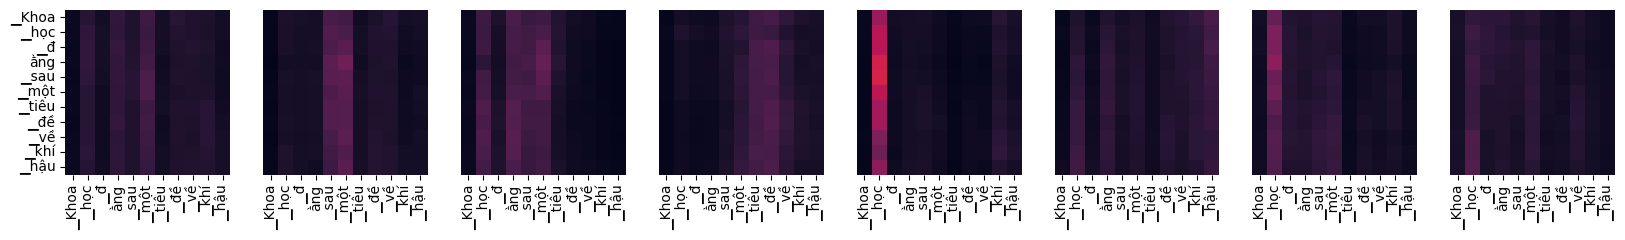

Encoder Layer 2


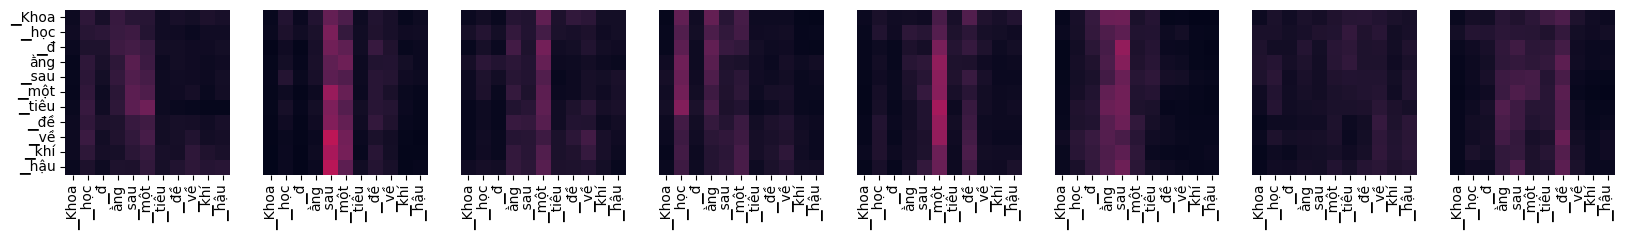

Encoder Layer 3


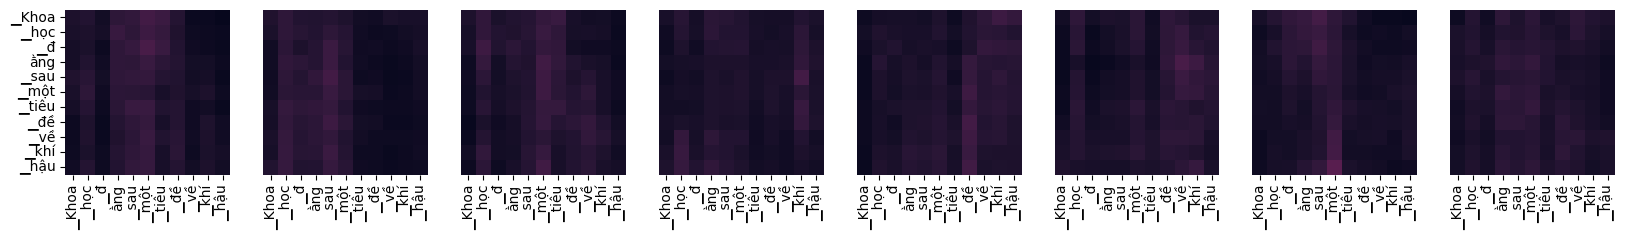

Decoder Self Layer 1


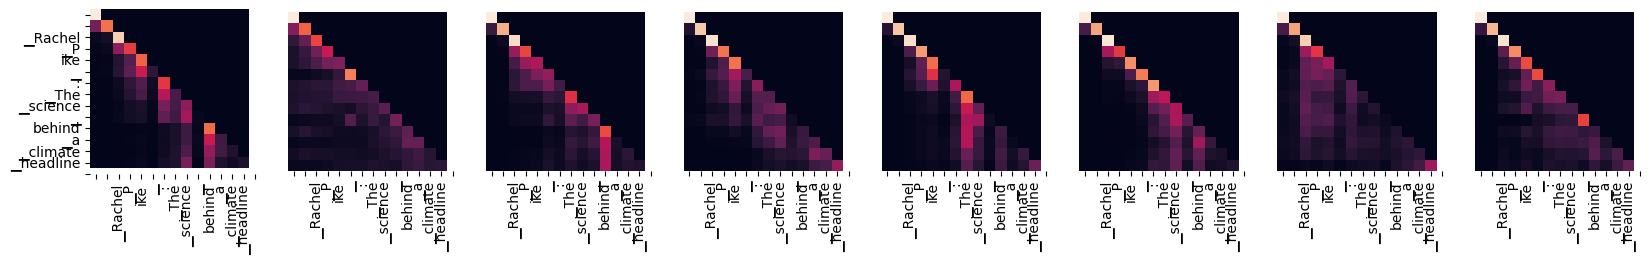

Decoder Src Layer 1


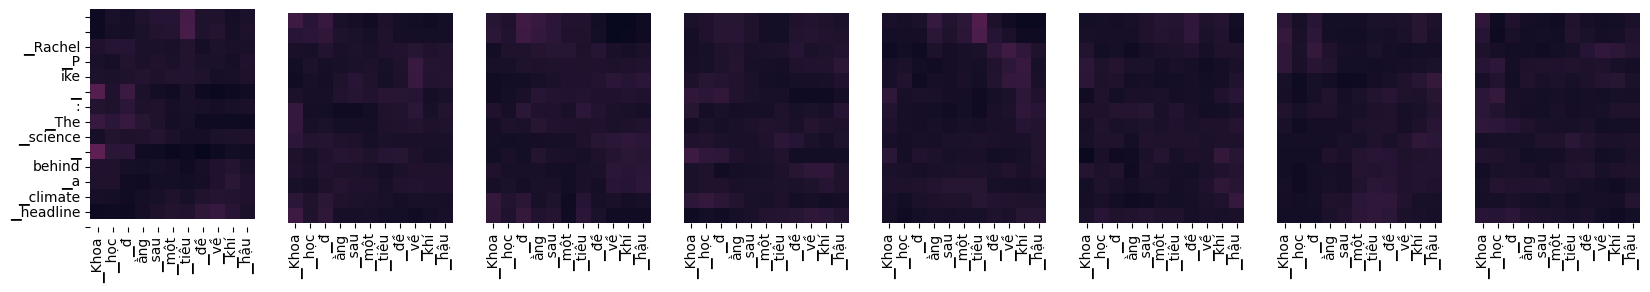

Decoder Self Layer 2


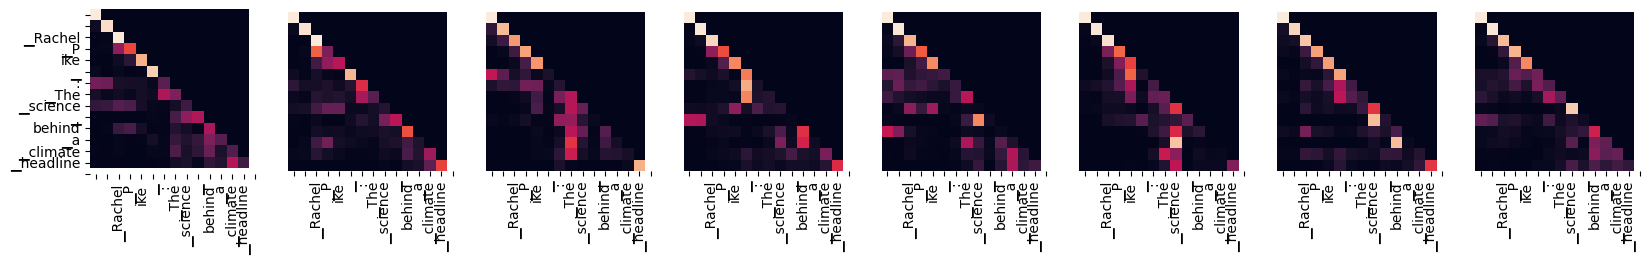

Decoder Src Layer 2


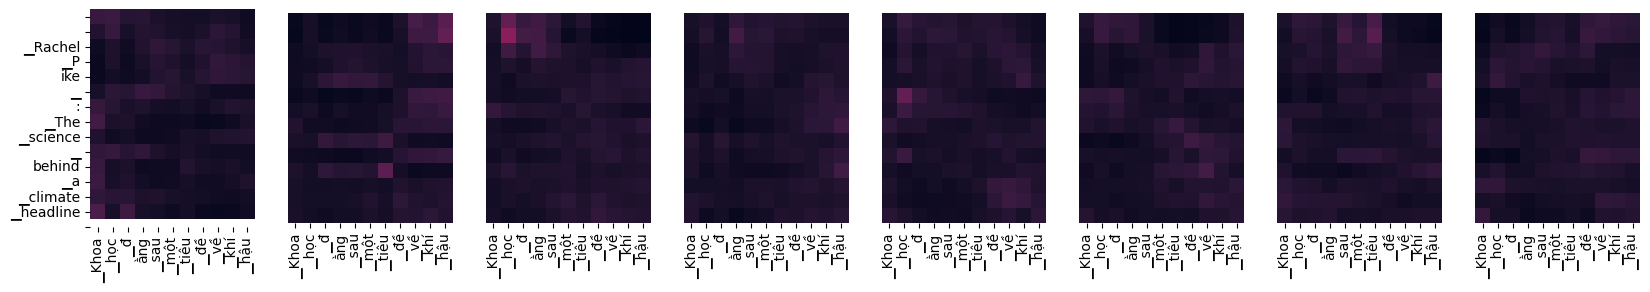

Decoder Self Layer 3


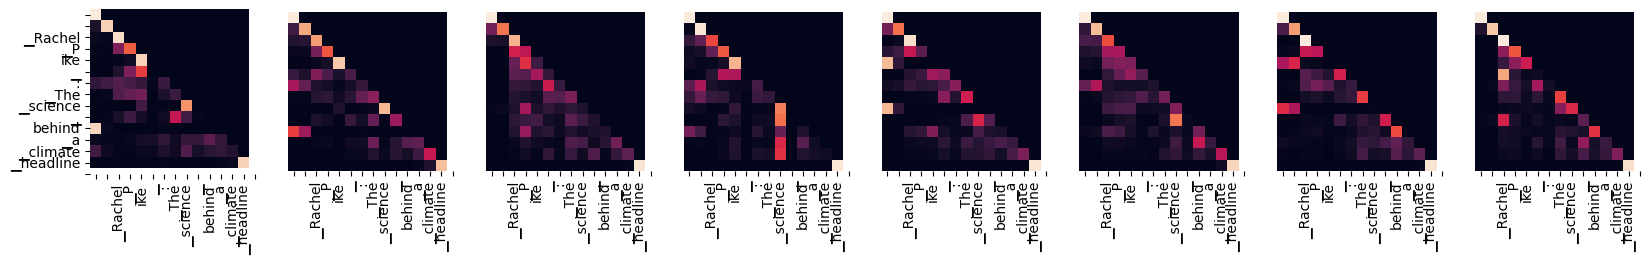

Decoder Src Layer 3


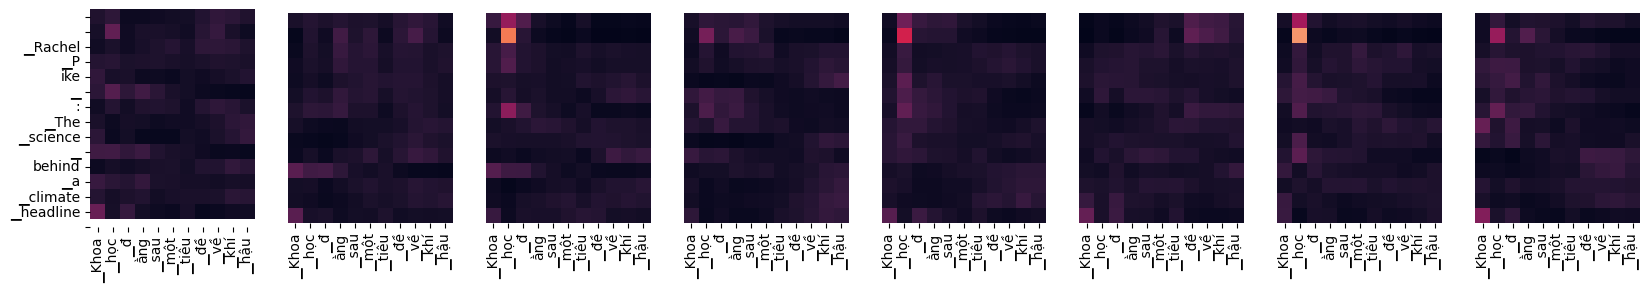

In [ ]:
import matplotlib.pyplot as plt
import seaborn

def draw_driver(n_encoder_layers, n_decoder_layers, n_heads, src, tgt):

    def draw(data, x, y, ax):
        seaborn.heatmap(data,
                        xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                        cbar=False, ax=ax)

    for layer in range(0, n_encoder_layers):
        fig, axs = plt.subplots(1, n_heads, figsize=(20, 10))
        print("Encoder Layer", layer+1)
        for h in range(n_heads):
            draw(encoder_save_outputs[layer].outputs[-1][0][h].cpu().data[:len(src), :len(src)],
                src, src if h == 0 else [], ax=axs[h])
        plt.show()

    for layer in range(0, n_decoder_layers):
        fig, axs = plt.subplots(1, n_heads, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(n_heads):
            draw(decoder_self_attn_save_outputs[layer].outputs[-1][0][h].cpu().data[:len(tgt), :len(tgt)],
                tgt, tgt if h ==0 else [], ax=axs[h])
        plt.show()
        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1,args.n_heads, figsize=(20, 10))
        for h in range(n_heads):
            draw(decoder_cross_attn_save_outputs[layer].outputs[-1][0][h].cpu().data[:len(tgt), :len(src)],
                src, tgt if h ==0 else [], ax=axs[h])
        plt.show()

MAX_SENTENCE_LENGTH_SHOWN = 25
draw_driver(args.n_encoder_layers, args.n_decoder_layers, args.n_heads, src_sentence[:MAX_SENTENCE_LENGTH_SHOWN], translation.split(' ')[:MAX_SENTENCE_LENGTH_SHOWN])

# Great work! You have completed all the tasks in this assignment 👏